In [4]:
import os
import pickle
from itertools import product

import seaborn as sns
import matplotlib
import matplotlib.pylab as plt
import numpy as np

from run_fl import generate_data, optimal_value, value

%load_ext autoreload
%autoreload 2

sns.set(style="whitegrid", font_scale=1.2, context="talk", palette=sns.color_palette("bright"), color_codes=False)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['figure.figsize'] = (8, 6)

In [6]:
%%html
<style>
.cell-output-ipywidget-background {
   background-color: transparent !important;
}
.jp-OutputArea-output {
   background-color: transparent;
}  
.jupyter-widgets {color: #d5d5d5 !important;}
.widget-label {color: #d5d5d5 !important;}
</style>


# x_0 = 1, dim = 100, batch = 100

In [21]:
dim = 100

In [22]:
data = generate_data(dim)
x_opt, f_opt = optimal_value(data)

In [23]:
f_opt

11235236.554068442

## Additional functions

In [24]:
def best_result(
    alg_type,
    results_dir,
    n_comms,
    cl_lr_list=[None],
    se_lr_list=[None],
    c_0_list=[None],
    c_1_list=[None],
    cl_cl_list=[None],
):
    min_val = np.inf
    best_result = None
    is_any_result = False
    for client_lr, server_lr, c_0, c_1, client_cl in product(cl_lr_list, se_lr_list, c_0_list, c_1_list, cl_cl_list):
    # for step_size, clip_level in product(step_size_list, clip_level_list):
        if alg_type == 'l_sgd_jump':
            result_fn = f'l_sgd_jump_cl_lr_{client_lr}_c_0_{c_0}_c_1_{c_1}_{n_comms}'
        elif alg_type == 'l0l1_gd':
            result_fn = f'gd_c_0_{c_0}_c_1_{c_1}_{n_comms}'
        elif alg_type == 'l_clip_sgd':
            result_fn = f'l_clip_sgd_c_0_{c_0}_c_1_{c_1}_{n_comms}'
        elif alg_type == 'clip_fedavg':
            result_fn = f'clip_fedavg_cl_lr_{client_lr}_se_lr_{server_lr}_cl_cl_{client_cl}_{n_comms}'
        else:
            raise NotImplementedError(f"{alg_type} is not implemented!")

        result_path = os.path.join(results_dir, result_fn)
        if not os.path.exists(result_path):
            continue

        with open(result_path, "rb") as f:
            result = {'loss': pickle.load(f)}
        best_result, min_val = update_best_result(
            best_result,
            min_val,
            result,
        )
        if best_result is not None:
            is_any_result = True
            if alg_type == 'l_sgd_jump':
                result['client_lr'] = client_lr
                result['c_0'] = c_0
                result['c_1'] = c_1
            elif alg_type == 'l_clip_sgd' or alg_type == 'l0l1_gd':
                result['c_0'] = c_0
                result['c_1'] = c_1
            elif alg_type == 'clip_fedavg':
                result['client_lr'] = client_lr
                result['server_lr'] = server_lr
                result['client_cl'] = client_cl

    assert is_any_result, f"There are no saved results!, {result_path}"

    return best_result


def update_best_result(best_result, min_val, result):
    mean_loss_vals = 0
    for seed in result['loss']:
        loss_val_seed = result['loss'][seed]
        last_part = loss_val_seed[-len(loss_val_seed) // 4 :]
        mean_loss_vals += np.mean(last_part)
    if mean_loss_vals < min_val:
        min_val = mean_loss_vals
        best_result = result
    return best_result, min_val

In [25]:
def plot_result(result, label, fill_between=True, ax=None, line_style=None, color=None, f_opt=None):
    seed_values = result["loss"]
    if f_opt is None:
        mean = np.mean(np.array(list(seed_values.values())), axis=0)
    else:
        mean = np.mean(np.array(list(seed_values.values())) - f_opt, axis=0)
    if fill_between:
        if f_opt is None:
            std = np.std(np.array(list(seed_values.values())), axis=0)
        else:
            std = np.std(np.array(list(seed_values.values())) - f_opt, axis=0)
    if ax is None:
        plt.plot(mean, label=label, linestyle=line_style, color=color)
        if fill_between:
            plt.fill_between(
                range(len(mean)), mean - std, mean + std, alpha=0.2, color=color
            )
    else:
        ax.plot(mean, label=label, linestyle=line_style, color=color)
        if fill_between:
            ax.fill_between(
                range(len(mean)), mean - std, mean + std, alpha=0.2, color=color
            )

In [26]:
x_0 = 1. # actually ones(dim) * 100
n_comms = 200
batch_size = 100

## L0-L1-GD

### Parameters

In [27]:
c_0_min = -10
c_0_max = 6
c_1_min = -10
c_1_max = 6

In [28]:
c_0_list = np.logspace(c_0_min, c_0_max, c_0_max - c_0_min + 1)
c_1_list = np.logspace(c_1_min, c_1_max, c_1_max - c_1_min + 1)
c_0_list, c_1_list

(array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
        1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
        1.e+06]),
 array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
        1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
        1.e+06]))

### Best result

In [29]:
l0l1gd_best_result = best_result(
    'l0l1_gd', 
    f'results/fl_fourth_order/dim_{dim}/x_0_{x_0}/gd', 
    n_comms, 
    c_0_list=c_0_list,
    c_1_list=c_1_list
)
l0l1gd_best_result['c_0'], l0l1gd_best_result['c_1']

(10000.0, 1e-10)

## Local-SGD with jumping

### Parameters

In [30]:
client_lr_min = -10
client_lr_max = 0
c_0_min = -10
c_0_max = 6
c_1_min = -10
c_1_max = 6

In [31]:
client_lr_list = np.logspace(client_lr_min, client_lr_max, client_lr_max - client_lr_min + 1)
c_0_list = np.logspace(c_0_min, c_0_max, c_0_max - c_0_min + 1)
c_1_list = np.logspace(c_1_min, c_1_max, c_1_max - c_1_min + 1)
client_lr_list, c_0_list, c_1_list

(array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
        1.e-02, 1.e-01, 1.e+00]),
 array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
        1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
        1.e+06]),
 array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
        1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
        1.e+06]))

### Best result

In [32]:
lsgdj_best_result_per_tau = {}

In [33]:
n_local_steps = 1

In [34]:
lsgdj_best_result = best_result(
    'l_sgd_jump', 
    f'results/fl_fourth_order/dim_{dim}/x_0_{x_0}/tau_{n_local_steps}/bs_{batch_size}_no_ret', 
    n_comms, 
    cl_lr_list=client_lr_list,
    c_0_list=c_0_list,
    c_1_list=c_1_list
)
lsgdj_best_result_per_tau[n_local_steps] = lsgdj_best_result
lsgdj_best_result['client_lr'], lsgdj_best_result['c_0'], lsgdj_best_result['c_1']

(1e-10, 10000.0, 1e-10)

In [35]:
n_local_steps = 10

In [36]:
lsgdj_best_result = best_result(
    'l_sgd_jump', 
    f'results/fl_fourth_order/dim_{dim}/x_0_{x_0}/tau_{n_local_steps}/bs_{batch_size}_no_ret', 
    n_comms, 
    cl_lr_list=client_lr_list,
    c_0_list=c_0_list,
    c_1_list=c_1_list
)
lsgdj_best_result_per_tau[n_local_steps] = lsgdj_best_result
lsgdj_best_result['client_lr'], lsgdj_best_result['c_0'], lsgdj_best_result['c_1']

(1e-10, 10000.0, 1e-10)

## Local-clip-SGD

### Parameters

In [37]:
c_0_min = -15
c_0_max = 10
c_1_min = -15
c_1_max = 10

In [38]:
c_0_list = np.logspace(c_0_min, c_0_max, c_0_max - c_0_min + 1)
c_1_list = np.logspace(c_1_min, c_1_max, c_1_max - c_1_min + 1)
c_0_list, c_1_list

(array([1.e-15, 1.e-14, 1.e-13, 1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08,
        1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00,
        1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08,
        1.e+09, 1.e+10]),
 array([1.e-15, 1.e-14, 1.e-13, 1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08,
        1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00,
        1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08,
        1.e+09, 1.e+10]))

### Best result

In [39]:
lcsgd_best_result_per_tau = {}

In [40]:
n_local_steps = 1

In [41]:
lcsgd_best_result = best_result(
    'l_clip_sgd', 
    f'results/fl_fourth_order/dim_{dim}/x_0_{x_0}/tau_{n_local_steps}/bs_{batch_size}_no_ret', 
    n_comms, 
    c_0_list=c_0_list,
    c_1_list=c_1_list
)
lcsgd_best_result_per_tau[n_local_steps] = lcsgd_best_result
lcsgd_best_result['c_0'], lcsgd_best_result['c_1']

(10000.0, 1e-10)

In [42]:
n_local_steps = 10

In [43]:
lcsgd_best_result = best_result(
    'l_clip_sgd', 
    f'results/fl_fourth_order/dim_{dim}/x_0_{x_0}/tau_{n_local_steps}/bs_{batch_size}_no_ret', 
    n_comms, 
    c_0_list=c_0_list,
    c_1_list=c_1_list
)
lcsgd_best_result_per_tau[n_local_steps] = lcsgd_best_result
lcsgd_best_result['c_0'], lcsgd_best_result['c_1']

(1000000.0, 1e-15)

## Clipping enabled FedAvg

### Parameters

In [44]:
server_lr_min = -10
server_lr_max = 3
client_lr_min = -10
client_lr_max = 0
client_cl_min = 0
client_cl_max = 4

In [45]:
server_lr_list = np.logspace(server_lr_min, server_lr_max, server_lr_max - server_lr_min + 1)
client_lr_list = np.logspace(client_lr_min, client_lr_max, client_lr_max - client_lr_min + 1)
client_cl_list = np.logspace(client_cl_min, client_cl_max, client_cl_max - client_cl_min + 1)
server_lr_list, client_lr_list, client_cl_list

(array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
        1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
        1.e-02, 1.e-01, 1.e+00]),
 array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04]))

### Best result

In [46]:
cfedavg_best_result_per_tau = {}

In [47]:
n_local_steps = 1

In [48]:
cfedavg_best_result = best_result(
    'clip_fedavg', 
    f'results/fl_fourth_order/dim_{dim}/x_0_{x_0}/tau_{n_local_steps}/bs_{batch_size}_no_ret', 
    n_comms, 
    se_lr_list=server_lr_list,
    cl_lr_list=client_lr_list,
    cl_cl_list=client_cl_list
)
cfedavg_best_result_per_tau[n_local_steps] = cfedavg_best_result
cfedavg_best_result['server_lr'], cfedavg_best_result['client_lr'], cfedavg_best_result['client_cl']

(1.0, 0.0001, 10.0)

In [49]:
n_local_steps = 10

In [50]:
cfedavg_best_result = best_result(
    'clip_fedavg', 
    f'results/fl_fourth_order/dim_{dim}/x_0_{x_0}/tau_{n_local_steps}/bs_{batch_size}_no_ret', 
    n_comms, 
    se_lr_list=server_lr_list,
    cl_lr_list=client_lr_list,
    cl_cl_list=client_cl_list
)
cfedavg_best_result_per_tau[n_local_steps] = cfedavg_best_result
cfedavg_best_result['server_lr'], cfedavg_best_result['client_lr'], cfedavg_best_result['client_cl']

(1000.0, 1e-08, 1.0)

## Plots

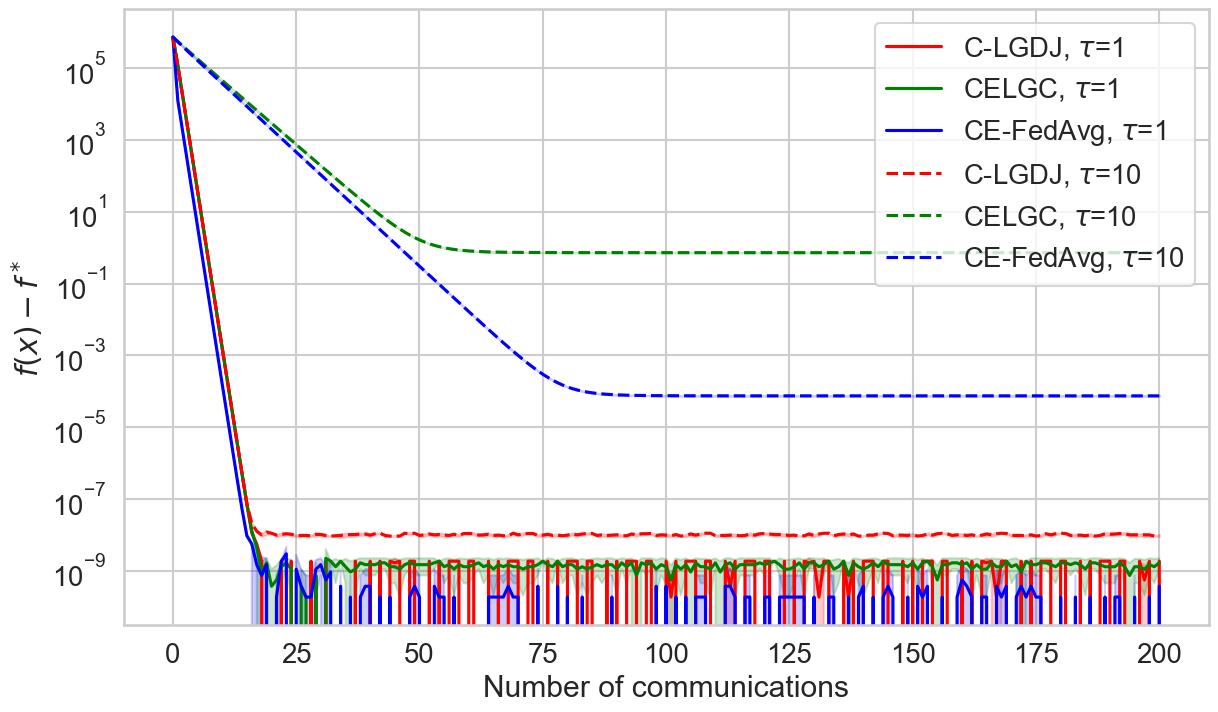

In [ ]:
fig = plt.figure(figsize=(14, 8))
colors = ['red', 'blue', 'green', 'orange']
line_styles = ['-', '--']
for i, tau in enumerate(lsgdj_best_result_per_tau):
    lsgdj_best_result = lsgdj_best_result_per_tau[tau]
    lsgdj_lbl = fr'C-LGDJ, $\tau$={tau}'
    plot_result(lsgdj_best_result, lsgdj_lbl, True, color='red', line_style=line_styles[i], f_opt=f_opt)

    lcsgd_best_result = lcsgd_best_result_per_tau[tau]
    lcsgd_lbl = fr'CELGC, $\tau$={tau}'
    plot_result(lcsgd_best_result, lcsgd_lbl, True, color='green', line_style=line_styles[i], f_opt=f_opt)

    cfedavg_best_result = cfedavg_best_result_per_tau[tau]
    cfedavg_lbl = fr'CE-FedAvg, $\tau$={tau}'
    plot_result(cfedavg_best_result, cfedavg_lbl, True, color='blue', line_style=line_styles[i], f_opt=f_opt)

# l0l1gd_lbl = fr'L0-L1-GD, c_0={l0l1gd_best_result['c_0']}, c_1={l0l1gd_best_result['c_1']}'
# plot_result(l0l1gd_best_result, l0l1gd_lbl, True, color='orange', f_opt=f_opt)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.title(fr'x_0={x_0}, batch size={batch_size}, $\tau$={n_local_steps}')
plt.legend()
plt.ylabel(r'$f(x) - f^*$')
plt.xlabel('Number of communications')
plt.yscale('log')
plt.savefig(f'plots/lsgdj/fourth_order_x_0_{x_0}_no_params.png', bbox_inches='tight')

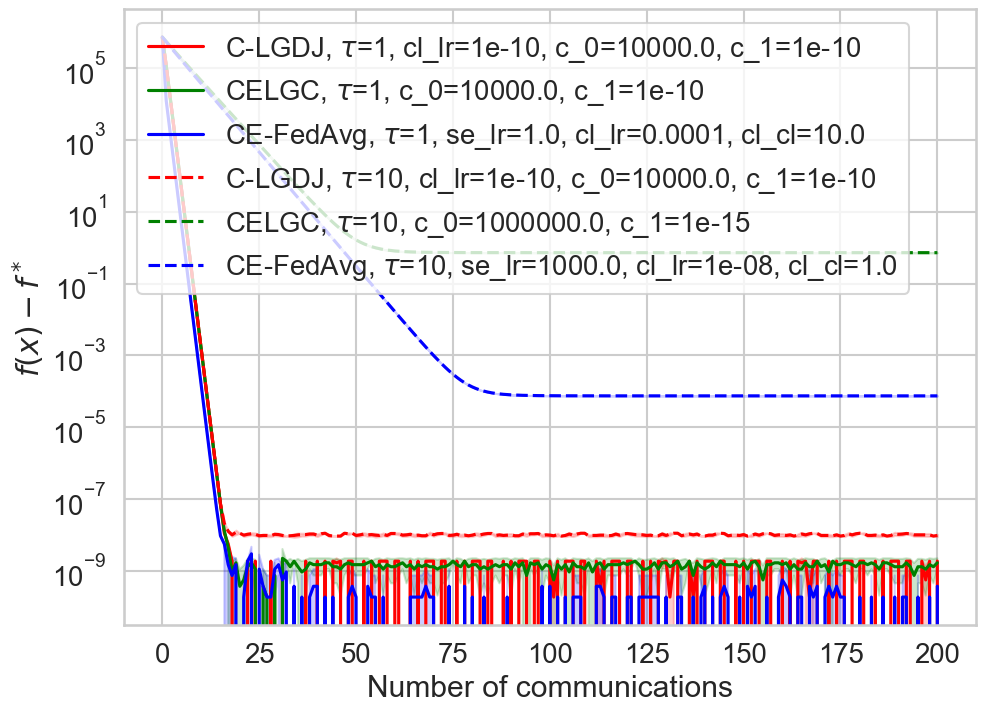

In [99]:
fig = plt.figure(figsize=(11, 8))
colors = ['red', 'blue', 'green', 'orange']
line_styles = ['-', '--']
for i, tau in enumerate(lsgdj_best_result_per_tau):
    lsgdj_best_result = lsgdj_best_result_per_tau[tau]
    lsgdj_lbl = fr'C-LGDJ, $\tau$={tau}, cl_lr={lsgdj_best_result['client_lr']}, c_0={lsgdj_best_result['c_0']}, c_1={lsgdj_best_result['c_1']}'
    plot_result(lsgdj_best_result, lsgdj_lbl, True, color='red', line_style=line_styles[i], f_opt=f_opt)

    lcsgd_best_result = lcsgd_best_result_per_tau[tau]
    lcsgd_lbl = fr'CELGC, $\tau$={tau}, c_0={lcsgd_best_result['c_0']}, c_1={lcsgd_best_result['c_1']}'
    plot_result(lcsgd_best_result, lcsgd_lbl, True, color='green', line_style=line_styles[i], f_opt=f_opt)

    cfedavg_best_result = cfedavg_best_result_per_tau[tau]
    cfedavg_lbl = fr'CE-FedAvg, $\tau$={tau}, se_lr={cfedavg_best_result['server_lr']}, cl_lr={cfedavg_best_result['client_lr']}, cl_cl={cfedavg_best_result['client_cl']}'
    plot_result(cfedavg_best_result, cfedavg_lbl, True, color='blue', line_style=line_styles[i], f_opt=f_opt)

# l0l1gd_lbl = fr'L0-L1-GD, c_0={l0l1gd_best_result['c_0']}, c_1={l0l1gd_best_result['c_1']}'
# plot_result(l0l1gd_best_result, l0l1gd_lbl, True, color='orange', f_opt=f_opt)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.title(fr'x_0={x_0}, batch size={batch_size}, $\tau$={n_local_steps}')
plt.legend(loc='upper left')
plt.ylabel(r'$f(x) - f^*$')
plt.xlabel('Number of communications')
plt.yscale('log')
plt.savefig(f'plots/lsgdj/fourth_order_x_0_{x_0}.png', bbox_inches='tight')

# x_0 = 10, dim = 100, batch = 100

In [82]:
dim = 100

In [83]:
data = generate_data(dim)
x_opt, f_opt = optimal_value(data)

## Additional functions

In [84]:
def best_result(
    alg_type,
    results_dir,
    n_comms,
    cl_lr_list=[None],
    se_lr_list=[None],
    c_0_list=[None],
    c_1_list=[None],
    cl_cl_list=[None],
):
    min_val = np.inf
    best_result = None
    is_any_result = False
    for client_lr, server_lr, c_0, c_1, client_cl in product(cl_lr_list, se_lr_list, c_0_list, c_1_list, cl_cl_list):
    # for step_size, clip_level in product(step_size_list, clip_level_list):
        if alg_type == 'l_sgd_jump':
            result_fn = f'l_sgd_jump_cl_lr_{client_lr}_c_0_{c_0}_c_1_{c_1}_{n_comms}'
        elif alg_type == 'l0l1_gd':
            result_fn = f'gd_c_0_{c_0}_c_1_{c_1}_{n_comms}'
        elif alg_type == 'l_clip_sgd':
            result_fn = f'l_clip_sgd_c_0_{c_0}_c_1_{c_1}_{n_comms}'
        elif alg_type == 'clip_fedavg':
            result_fn = f'clip_fedavg_cl_lr_{client_lr}_se_lr_{server_lr}_cl_cl_{client_cl}_{n_comms}'
        else:
            raise NotImplementedError(f"{alg_type} is not implemented!")

        result_path = os.path.join(results_dir, result_fn)
        if not os.path.exists(result_path):
            continue

        with open(result_path, "rb") as f:
            result = {'loss': pickle.load(f)}
        best_result, min_val = update_best_result(
            best_result,
            min_val,
            result,
        )
        if best_result is not None:
            is_any_result = True
            if alg_type == 'l_sgd_jump':
                result['client_lr'] = client_lr
                result['c_0'] = c_0
                result['c_1'] = c_1
            elif alg_type == 'l_clip_sgd' or alg_type == 'l0l1_gd':
                result['c_0'] = c_0
                result['c_1'] = c_1
            elif alg_type == 'clip_fedavg':
                result['client_lr'] = client_lr
                result['server_lr'] = server_lr
                result['client_cl'] = client_cl

    assert is_any_result, f"There are no saved results!, {result_path}"

    return best_result


def update_best_result(best_result, min_val, result):
    mean_loss_vals = 0
    for seed in result['loss']:
        loss_val_seed = result['loss'][seed]
        last_part = loss_val_seed[-len(loss_val_seed) // 4 :]
        mean_loss_vals += np.mean(last_part)
    if mean_loss_vals < min_val:
        min_val = mean_loss_vals
        best_result = result
    return best_result, min_val

In [85]:
def plot_result(result, label, fill_between=True, ax=None, line_style=None, color=None, f_opt=None):
    seed_values = result["loss"]
    if f_opt is None:
        mean = np.mean(np.array(list(seed_values.values())), axis=0)
    else:
        mean = np.mean(np.array(list(seed_values.values())) - f_opt, axis=0)
    if fill_between:
        if f_opt is None:
            std = np.std(np.array(list(seed_values.values())), axis=0)
        else:
            std = np.std(np.array(list(seed_values.values())) - f_opt, axis=0)
    if ax is None:
        plt.plot(mean, label=label, linestyle=line_style, color=color)
        if fill_between:
            plt.fill_between(
                range(len(mean)), mean - std, mean + std, alpha=0.2, color=color
            )
    else:
        ax.plot(mean, label=label, linestyle=line_style, color=color)
        if fill_between:
            ax.fill_between(
                range(len(mean)), mean - std, mean + std, alpha=0.2, color=color
            )

In [86]:
x_0 = 10. # actually ones(dim) * x_0
n_comms = 200
batch_size = 100

## L0-L1-GD

### Parameters

In [87]:
c_0_min = -10
c_0_max = 6
c_1_min = -10
c_1_max = 6

In [88]:
c_0_list = np.logspace(c_0_min, c_0_max, c_0_max - c_0_min + 1)
c_1_list = np.logspace(c_1_min, c_1_max, c_1_max - c_1_min + 1)
c_0_list, c_1_list

(array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
        1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
        1.e+06]),
 array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
        1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
        1.e+06]))

### Best result

In [89]:
l0l1gd_best_result = best_result(
    'l0l1_gd', 
    f'results/fl_fourth_order/dim_{dim}/x_0_{x_0}/gd', 
    n_comms, 
    c_0_list=c_0_list,
    c_1_list=c_1_list
)
l0l1gd_best_result['c_0'], l0l1gd_best_result['c_1']

(10000.0, 0.01)

## Local-SGD with jumping

### Parameters

In [90]:
client_lr_min = -10
client_lr_max = 0
c_0_min = -10
c_0_max = 6
c_1_min = -10
c_1_max = 6

In [91]:
client_lr_list = np.logspace(client_lr_min, client_lr_max, client_lr_max - client_lr_min + 1)
c_0_list = np.logspace(c_0_min, c_0_max, c_0_max - c_0_min + 1)
c_1_list = np.logspace(c_1_min, c_1_max, c_1_max - c_1_min + 1)
client_lr_list, c_0_list, c_1_list

(array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
        1.e-02, 1.e-01, 1.e+00]),
 array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
        1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
        1.e+06]),
 array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
        1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
        1.e+06]))

### Best result

In [92]:
lsgdj_best_result_per_tau = {}

In [93]:
n_local_steps = 1

In [94]:
lsgdj_best_result = best_result(
    'l_sgd_jump', 
    f'results/fl_fourth_order/dim_{dim}/x_0_{x_0}/tau_{n_local_steps}/bs_{batch_size}_no_ret', 
    n_comms, 
    cl_lr_list=client_lr_list,
    c_0_list=c_0_list,
    c_1_list=c_1_list
)
lsgdj_best_result_per_tau[n_local_steps] = lsgdj_best_result
lsgdj_best_result['client_lr'], lsgdj_best_result['c_0'], lsgdj_best_result['c_1']

(1e-10, 10000.0, 0.01)

In [95]:
n_local_steps = 10

In [96]:
lsgdj_best_result = best_result(
    'l_sgd_jump', 
    f'results/fl_fourth_order/dim_{dim}/x_0_{x_0}/tau_{n_local_steps}/bs_{batch_size}_no_ret', 
    n_comms, 
    cl_lr_list=client_lr_list,
    c_0_list=c_0_list,
    c_1_list=c_1_list
)
lsgdj_best_result_per_tau[n_local_steps] = lsgdj_best_result
lsgdj_best_result['client_lr'], lsgdj_best_result['c_0'], lsgdj_best_result['c_1']

(1e-10, 10000.0, 0.01)

In [99]:
len(lsgdj_best_result['loss'])

10

## Local-clip-SGD

### Parameters

In [67]:
c_0_min = -10
c_0_max = 10
c_1_min = -10
c_1_max = 10

In [68]:
c_0_list = np.logspace(c_0_min, c_0_max, c_0_max - c_0_min + 1)
c_1_list = np.logspace(c_1_min, c_1_max, c_1_max - c_1_min + 1)
c_0_list, c_1_list

(array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
        1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
        1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]),
 array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
        1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
        1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]))

### Best result

In [69]:
lcsgd_best_result_per_tau = {}

In [70]:
n_local_steps = 1

In [71]:
lcsgd_best_result = best_result(
    'l_clip_sgd', 
    f'results/fl_fourth_order/dim_{dim}/x_0_{x_0}/tau_{n_local_steps}/bs_{batch_size}_no_ret', 
    n_comms, 
    c_0_list=c_0_list,
    c_1_list=c_1_list
)
lcsgd_best_result_per_tau[n_local_steps] = lcsgd_best_result
lcsgd_best_result['c_0'], lcsgd_best_result['c_1']

(100000.0, 1e-10)

In [72]:
n_local_steps = 10

In [73]:
lcsgd_best_result = best_result(
    'l_clip_sgd', 
    f'results/fl_fourth_order/dim_{dim}/x_0_{x_0}/tau_{n_local_steps}/bs_{batch_size}_no_ret', 
    n_comms, 
    c_0_list=c_0_list,
    c_1_list=c_1_list
)
lcsgd_best_result_per_tau[n_local_steps] = lcsgd_best_result
lcsgd_best_result['c_0'], lcsgd_best_result['c_1']

(1000000.0, 1e-10)

## Clipping enabled FedAvg

### Parameters

In [74]:
server_lr_min = -10
server_lr_max = 0
client_lr_min = -10
client_lr_max = 0
client_cl_min = 0
client_cl_max = 4

In [75]:
server_lr_list = np.logspace(server_lr_min, server_lr_max, server_lr_max - server_lr_min + 1)
client_lr_list = np.logspace(client_lr_min, client_lr_max, client_lr_max - client_lr_min + 1)
client_cl_list = np.logspace(client_cl_min, client_cl_max, client_cl_max - client_cl_min + 1)
server_lr_list, client_lr_list, client_cl_list

(array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
        1.e-02, 1.e-01, 1.e+00]),
 array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
        1.e-02, 1.e-01, 1.e+00]),
 array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04]))

### Best result

In [76]:
cfedavg_best_result_per_tau = {}

In [77]:
n_local_steps = 1

In [78]:
cfedavg_best_result = best_result(
    'clip_fedavg', 
    f'results/fl_fourth_order/dim_{dim}/x_0_{x_0}/tau_{n_local_steps}/bs_{batch_size}_no_ret', 
    n_comms, 
    se_lr_list=server_lr_list,
    cl_lr_list=client_lr_list,
    cl_cl_list=client_cl_list
)
cfedavg_best_result_per_tau[n_local_steps] = cfedavg_best_result
cfedavg_best_result['server_lr'], cfedavg_best_result['client_lr'], cfedavg_best_result['client_cl']

(1.0, 1e-05, 10.0)

In [79]:
n_local_steps = 10

In [80]:
cfedavg_best_result = best_result(
    'clip_fedavg', 
    f'results/fl_fourth_order/dim_{dim}/x_0_{x_0}/tau_{n_local_steps}/bs_{batch_size}_no_ret', 
    n_comms, 
    se_lr_list=server_lr_list,
    cl_lr_list=client_lr_list,
    cl_cl_list=client_cl_list
)
cfedavg_best_result_per_tau[n_local_steps] = cfedavg_best_result
cfedavg_best_result['server_lr'], cfedavg_best_result['client_lr'], cfedavg_best_result['client_cl']

(1.0, 1e-05, 10.0)

## Plots

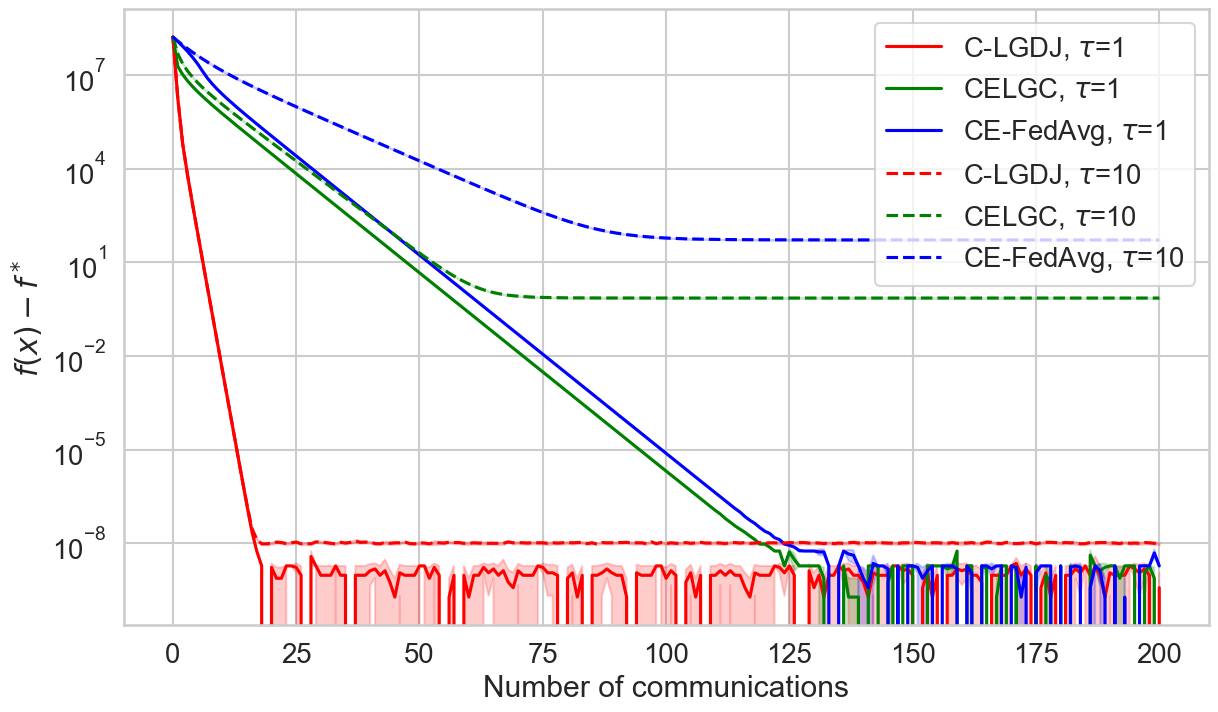

In [ ]:
fig = plt.figure(figsize=(14, 8))
colors = ['red', 'blue', 'green', 'orange']
line_styles = ['-', '--']
for i, tau in enumerate(lsgdj_best_result_per_tau):
    lsgdj_best_result = lsgdj_best_result_per_tau[tau]
    lsgdj_lbl = fr'C-LGDJ, $\tau$={tau}'
    plot_result(lsgdj_best_result, lsgdj_lbl, True, color='red', line_style=line_styles[i], f_opt=f_opt)

    lcsgd_best_result = lcsgd_best_result_per_tau[tau]
    lcsgd_lbl = fr'CELGC, $\tau$={tau}'
    plot_result(lcsgd_best_result, lcsgd_lbl, True, color='green', line_style=line_styles[i], f_opt=f_opt)

    cfedavg_best_result = cfedavg_best_result_per_tau[tau]
    cfedavg_lbl = fr'CE-FedAvg, $\tau$={tau}'
    plot_result(cfedavg_best_result, cfedavg_lbl, True, color='blue', line_style=line_styles[i], f_opt=f_opt)

# l0l1gd_lbl = fr'L0-L1-GD, c_0={l0l1gd_best_result['c_0']}, c_1={l0l1gd_best_result['c_1']}'
# plot_result(l0l1gd_best_result, l0l1gd_lbl, True, color='orange', f_opt=f_opt)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.title(fr'x_0={x_0}, batch size={batch_size}')
plt.legend()
plt.ylabel(r'$f(x) - f^*$')
plt.xlabel('Number of communications')
plt.yscale('log')
plt.savefig(f'plots/lsgdj/fourth_order_x_0_{x_0}_no_params.png', bbox_inches='tight')

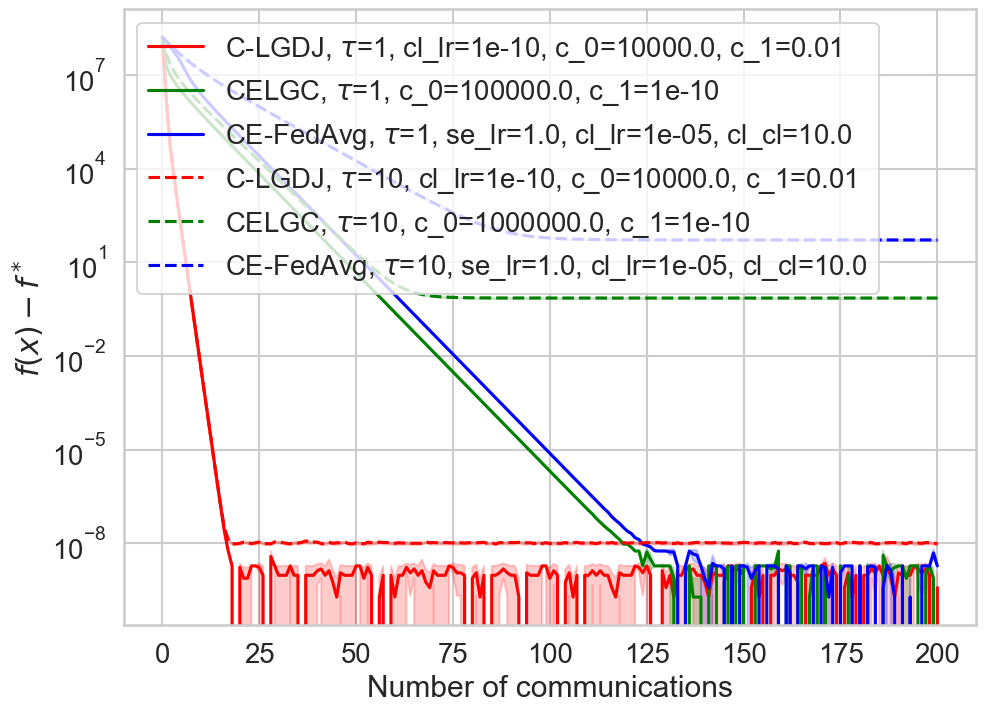

In [130]:
fig = plt.figure(figsize=(11, 8))
colors = ['red', 'blue', 'green', 'orange']
line_styles = ['-', '--']
for i, tau in enumerate(lsgdj_best_result_per_tau):
    lsgdj_best_result = lsgdj_best_result_per_tau[tau]
    lsgdj_lbl = fr'C-LGDJ, $\tau$={tau}, cl_lr={lsgdj_best_result['client_lr']}, c_0={lsgdj_best_result['c_0']}, c_1={lsgdj_best_result['c_1']}'
    plot_result(lsgdj_best_result, lsgdj_lbl, True, color='red', line_style=line_styles[i], f_opt=f_opt)

    lcsgd_best_result = lcsgd_best_result_per_tau[tau]
    lcsgd_lbl = fr'CELGC, $\tau$={tau}, c_0={lcsgd_best_result['c_0']}, c_1={lcsgd_best_result['c_1']}'
    plot_result(lcsgd_best_result, lcsgd_lbl, True, color='green', line_style=line_styles[i], f_opt=f_opt)

    cfedavg_best_result = cfedavg_best_result_per_tau[tau]
    cfedavg_lbl = fr'CE-FedAvg, $\tau$={tau}, se_lr={cfedavg_best_result['server_lr']}, cl_lr={cfedavg_best_result['client_lr']}, cl_cl={cfedavg_best_result['client_cl']}'
    plot_result(cfedavg_best_result, cfedavg_lbl, True, color='blue', line_style=line_styles[i], f_opt=f_opt)

# l0l1gd_lbl = fr'L0-L1-GD, c_0={l0l1gd_best_result['c_0']}, c_1={l0l1gd_best_result['c_1']}'
# plot_result(l0l1gd_best_result, l0l1gd_lbl, True, color='orange', f_opt=f_opt)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.title(fr'x_0={x_0}, batch size={batch_size}')
plt.legend(loc='upper left')
plt.ylabel(r'$f(x) - f^*$')
plt.xlabel('Number of communications')
plt.yscale('log')
plt.savefig(f'plots/lsgdj/fourth_order_x_0_{x_0}.png', bbox_inches='tight')